In [546]:
#Прогноз цен на недвижимость в МСК
#
#

In [547]:
!pip install missingno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder

# Чтение данных из файла
file_path = '/Users/marina/Downloads/_data.csv'
data = pd.read_csv('_data.csv')

In [548]:
# Вывод колонок/признаков
columns = data.columns
print("Наименование признака:")
columns

Наименование признака:


Index(['Unnamed: 0', 'ID  объявления', 'Количество комнат', 'Тип', 'Метро',
       'Адрес', 'Площадь, м2', 'Дом', 'Парковка', 'Цена', 'Телефоны',
       'Описание', 'Ремонт', 'Площадь комнат, м2', 'Балкон', 'Окна', 'Санузел',
       'Можно с детьми/животными', 'Дополнительно', 'Название ЖК',
       'Серия дома', 'Высота потолков, м', 'Лифт', 'Мусоропровод',
       'Ссылка на объявление'],
      dtype='object')

In [549]:
# проверка на отсутствующие значения для всех колонок датафрейма
data.isnull().sum()

Unnamed: 0                      0
ID  объявления                  0
Количество комнат            1041
Тип                             0
Метро                        1315
Адрес                           0
Площадь, м2                     0
Дом                             0
Парковка                    13417
Цена                            0
Телефоны                        0
Описание                        0
Ремонт                       2755
Площадь комнат, м2           8910
Балкон                       7978
Окна                         6613
Санузел                      2672
Можно с детьми/животными     6096
Дополнительно                 357
Название ЖК                 17520
Серия дома                  21205
Высота потолков, м          12162
Лифт                         5500
Мусоропровод                10522
Ссылка на объявление            0
dtype: int64

In [550]:
#Раскладываем строку цена
for index, row in data.iterrows():
    parts = row['Цена'].split(', ')  # Разбиваем по запятой с пробелом
    for part in parts:
        if 'За месяц' in part:
            price = part.split(' ')[0]  # Извлекаем сумму за месяц
            # Преобразуем в числовое значение (float)
            data.at[index, 'price_monthly'] = float(''.join(filter(lambda x: x.isdigit() or x == '.', price)))
        elif 'Залог' in part:
            deposit = part.split(' ')[-2]  # Извлекаем сумму залога
            # Преобразуем в числовое значение (float)
            data.at[index, 'deposit'] = float(''.join(filter(lambda x: x.isdigit() or x == '.', deposit)))
        elif 'Предоплата' in part:
            prepayment = part.split(' ')[-2] if len(part.split(' ')) > 1 else None
            # Преобразуем в числовое значение (float)
            data.at[index, 'prepayment'] = float(''.join(filter(lambda x: x.isdigit(), str(prepayment))))
        elif 'Коммунальные услуги' in part:
            data.at[index, 'utility'] = 'включены'
# Вычисляем моду
mode_utility = data['utility'].mode()[0]
mode_deposit = data['deposit'].mode()[0]
mode_prepayment = data['prepayment'].mode()[0]

# Заполнение пропущенных значений в столбцах 'pledge' и 'deposit' модой
data['deposit'].fillna(mode_deposit, inplace=True)
data['prepayment'].fillna(mode_prepayment, inplace=True)
data['utility'].fillna(mode_utility, inplace=True)


# Показываем первые строки с новыми колонками
data[['price_monthly', 'deposit', 'prepayment', 'utility']].head()

,price_monthly,deposit,prepayment,utility
0,500000.0,500000.0,1.0,включены
1,500000.0,500000.0,1.0,включены
2,500000.0,500000.0,1.0,nan
3,400000.0,400000.0,1.0,nan
4,225000.0,225000.0,1.0,включены


<Axes: >

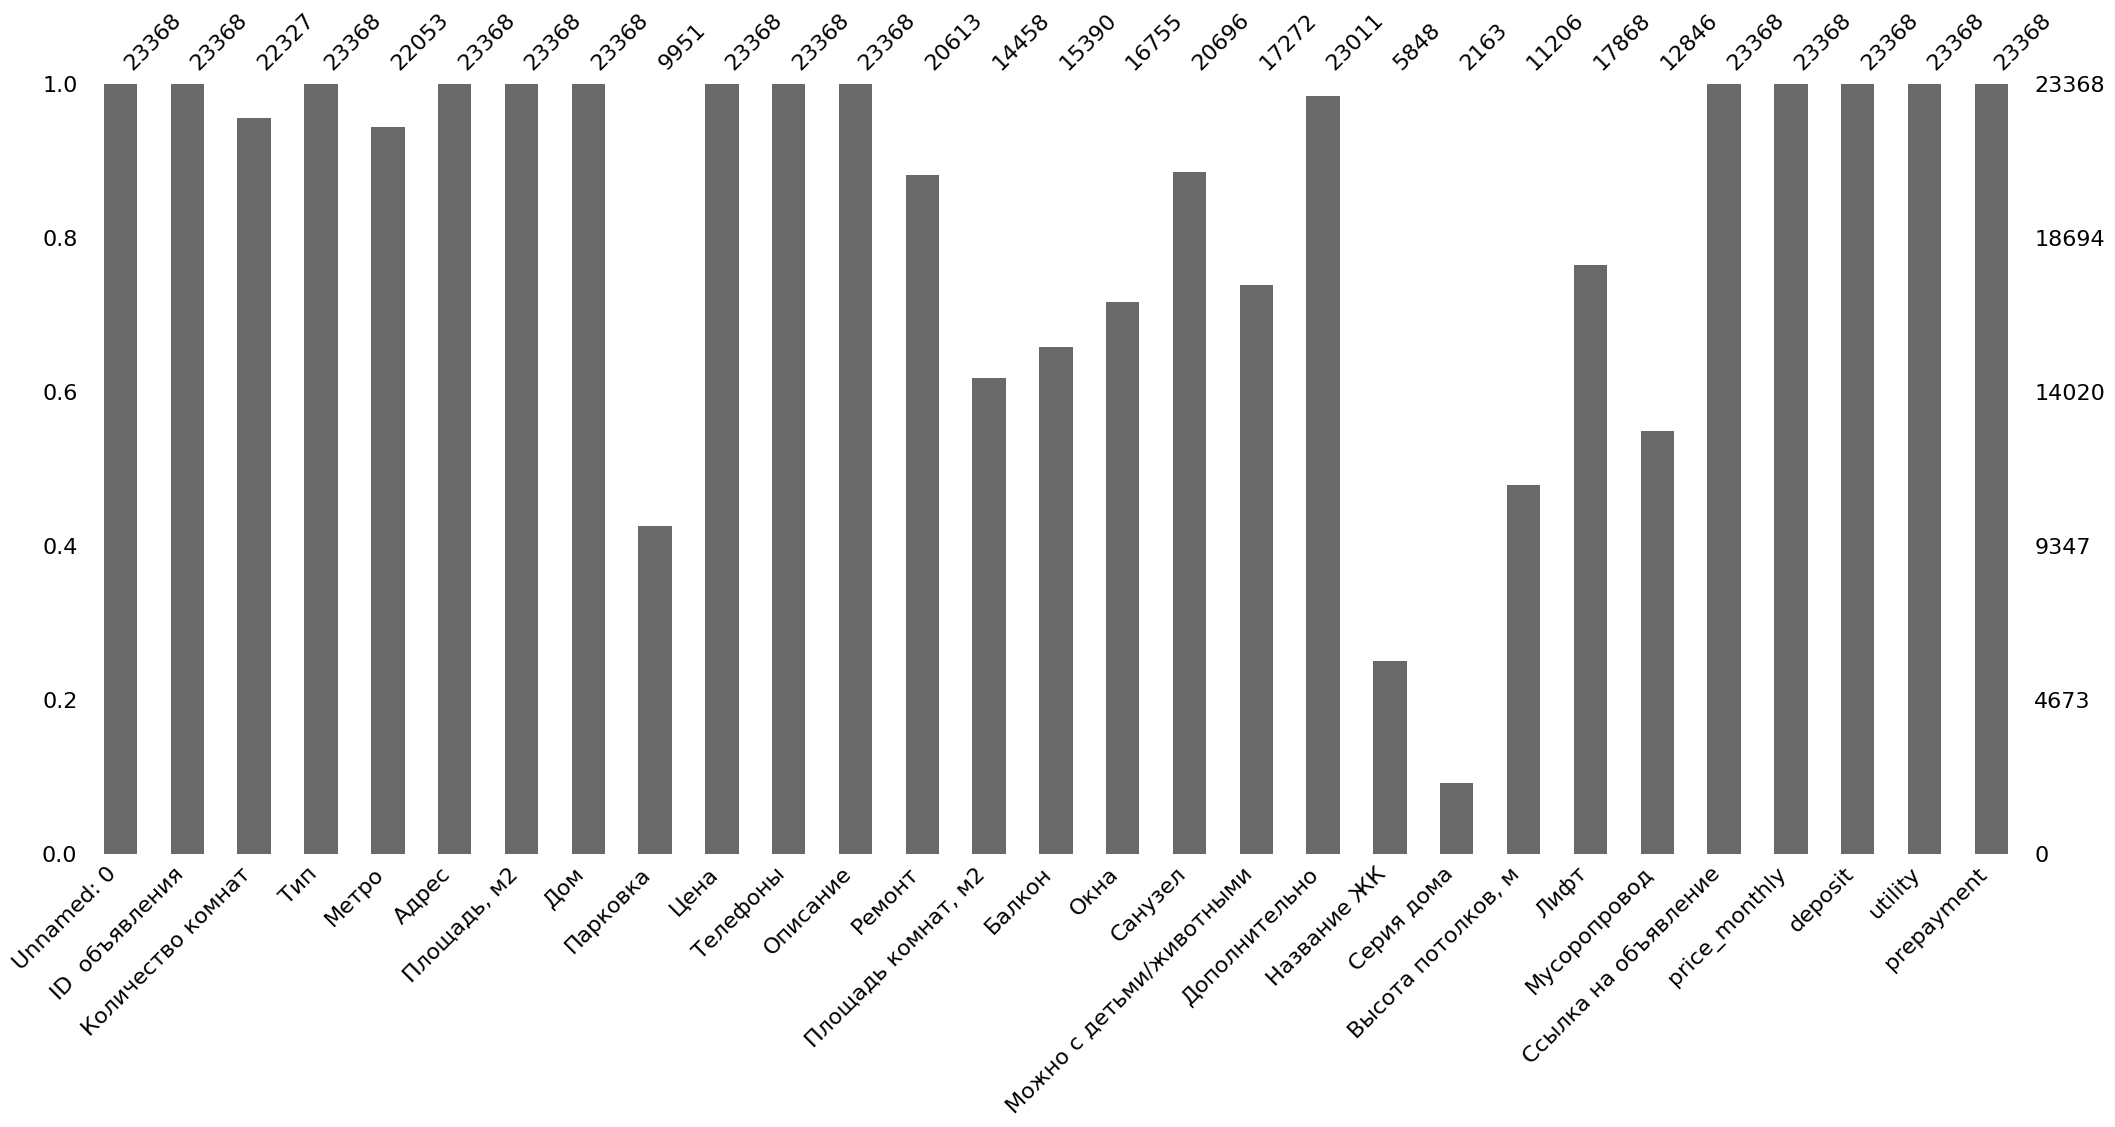

In [551]:
msno.bar(data)

In [552]:
data_clean = data.copy()

In [553]:
data_clean = data_clean.drop(columns = ['Название ЖК','Цена','Тип','Ссылка на объявление','Дополнительно', 'Unnamed: 0', 'Телефоны','ID  объявления','Описание'])

In [554]:
#перевести на англ. язык все колонки
data_clean.columns = [
    'number_of_rooms',
    'metro',
    'address',
    'area',
    'building',
    'parking',
    'renovation',
    'room_area',
    'balcony',
    'windows',
    'bathroom',
    'children/pets allowed',
    'building_series',
    'ceiling_height',
    'elevator',
    'trash_chute',
    'price_monthly',
    'deposit',
    'utility',
    'prepayment'
]

In [555]:
data_clean['number_of_rooms'] = data_clean['number_of_rooms'].str.extract(r'(\d+)') #очищу от букв столбец с кол-вом комнат

In [556]:
unique_values = data_clean['trash_chute'].unique()
unique_values

array(['Да', 'Нет', nan], dtype=object)

In [557]:
data_clean['trash_chute'] = data_clean['trash_chute'].replace({'Да': 1, 'Нет': 0, pd.NA: 0})

In [558]:
correlation = data_clean['price_monthly'].corr(data_clean['trash_chute'])
correlation

-0.12654849076962307

In [559]:
#отрицательный и низкий показатель коэф. корреляции, поэтому этот столбец можно исключить из выборки для машинного обучения

In [560]:
data_clean = data_clean.drop(columns = 'trash_chute')

In [561]:
data_clean['metro'] = data_clean['metro'].str.extract(r'(\d+)')

In [562]:
data_clean['metro'] = data_clean['metro'].astype(float)

In [563]:
mean_metro = data_clean['metro'].mean()
data_clean['metro'].fillna(mean_metro, inplace=True)

In [564]:
data_clean['prepayment'] #колонка была заполнена модой

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
23363    1.0
23364    1.0
23365    1.0
23366    2.0
23367    1.0
Name: prepayment, Length: 23368, dtype: float64

In [565]:
unique_values1 = data_clean['prepayment'].unique()
print(unique_values1)

[ 1.  2.  3. 11.  6. 12.]


In [566]:
data_clean['prepayment'].fillna(0, inplace=True)

In [567]:
data_clean.loc[data_clean['prepayment'] == 0, 'deposit'].fillna(0, inplace=True)#заполним пустые значения в предоплате 

In [568]:
data_clean = data_clean.drop(columns = 'building_series') #убираем тк не имеет важности

In [569]:
data_clean['area'] = data_clean['area'].apply(lambda x: x.split('/'))
data_clean['area'] = data_clean['area'].apply(lambda i: i[0])

In [570]:
data_clean['area'] = data_clean["area"].astype(float)

In [571]:
data_clean['number_of_rooms'] = data_clean['number_of_rooms'].fillna(data_clean['area']/40).astype(int)

In [572]:
data_clean = data_clean.drop(columns = 'room_area') 

In [573]:
data_clean = data_clean.drop(columns = 'prepayment') 

In [574]:
#случайные числа от 2.6 до 4.0 для заполнения NaN
random_values = np.random.uniform(2.6, 4.0, size=data_clean['ceiling_height'].isnull().sum())
#замена NaN случайными значениями от 2.6 до 4.0
data_clean.loc[data_clean['ceiling_height'].isnull(), 'ceiling_height'] = random_values

In [575]:
data_clean[['floors', 'type_house']] = data_clean['building'].str.split(', ', expand=True)
data_clean = data_clean.drop(columns = 'building') 

In [576]:
#неинформативными считаются признаки, в которых пропущено 20-30% информации, соответственно от балконов избавляемся

In [577]:
data_clean = data_clean.drop(columns=['balcony'])


In [578]:
data_clean[['current_floor', 'total_floors']] = data_clean['floors'].str.split('/', expand=True) #делим этажи
#на общее кол-во, и этаж опр. квартиры

In [579]:
data_clean = data_clean.drop(columns=['floors']) #исходный столбец убираем

In [580]:
def elevators_value(row): #заполняем столбец с лифтами, из рассчета, что если больше 5 этажей - нужен 1 лифт. Больше 10 - 2 
    if pd.isna(row['elevator']):
        if int(row['total_floors']) >= 10:
            a = int(row['total_floors'])
            return f'Пасс {a//10}, Груз {a//10}'
        elif int(row['total_floors']) > 5:
            return 'Пасс (1)'
        else:
            return '0'
    else:
        return row['elevator']

data_clean['elevator'] = data_clean.apply(elevators_value, axis=1)

In [581]:
data_clean.rename(columns={'children/pets allowed': 'children_pets_allowed'},inplace = True)

In [582]:
replace_dict = {
    'Можно с детьми': 1,
    'Можно с животными': 2,
    'Можно с детьми, Можно с животными': 3,
    '0': 0,  
}
data_clean['children_pets_allowed'] = data_clean['children_pets_allowed'].replace(replace_dict)
data_clean['children_pets_allowed']

0        3.0
1        1.0
2        1.0
3        2.0
4        NaN
        ... 
23363    NaN
23364    NaN
23365    1.0
23366    NaN
23367    3.0
Name: children_pets_allowed, Length: 23368, dtype: float64

In [583]:
correlation = data_clean['price_monthly'].corr(data_clean['children_pets_allowed'])
print(correlation) #низкая корреляция, убираем столбец

0.08942490532043243


In [584]:
data_clean = data_clean.drop(columns=['children_pets_allowed'])

In [585]:
windows_mapping = {None: -1, 'На улицу и двор': 0, 'Во двор': 1, 'На улицу': 2}
mode_windows = data_clean['windows'].mode()[0] #тут тоже используем моду
data_clean['windows'].fillna(mode_windows, inplace=True)

data_clean['windows'] = data_clean['windows'].map(windows_mapping)

In [586]:
renovation_mapping = {'Дизайнерский': 0, 'Евроремонт': 1, 'Косметический': 2, 'Без ремонта': 3}

# Заполняем пропущенные значения самым часто встречающимся
mode_renovation = data_clean['renovation'].mode()[0]
data_clean['renovation'].fillna(mode_renovation, inplace=True)

# Применяем map() для преобразования категорий в числа
data_clean['renovation'] = data_clean['renovation'].map(renovation_mapping)

In [587]:
def define_parking(row): #заполним парковку
    if pd.isna(row['parking']):
        if int(row['total_floors']) >= 15:
            return 'наземная'
        else:
            return 'подземная'
    else:
        return row['parking']

# Применение функции к DataFrame
data_clean['parking'] = data_clean.apply(define_parking, axis=1)

In [588]:
parking_mapping = {None: -1, 'подземная': 0, 'наземная': 1, 'открытая': 2, 'многоуровневая': 3, 'на крыше':4}
mode_parking = data_clean['parking'].mode()[0] #тут тоже используем моду
data_clean['parking'].fillna(mode_parking, inplace=True)

data_clean['parking'] = data_clean['parking'].map(parking_mapping)

In [589]:
unique_values1 = data_clean['type_house'].unique()
print(unique_values1)

['Монолитный' 'Монолитно-кирпичный' None 'Панельный' 'Сталинский'
 'Кирпичный' 'старый фонд' 'Блочный' 'Деревянный' 'Газобетонный блок'
 'Щитовой']


In [590]:
type_house_mapping = {None: -1, 'Монолитный': 0, 'Монолитно-кирпичный': 1, 'Панельный': 2, 'Сталинский': 3, 'Кирпичный':4, 'старый фонд':5,
                  'Блочный':6,'Деревянный':7,'Газобетонный блок':8,'Щитовой':9}
mode_type_house = data_clean['type_house'].mode()[0] #тут тоже используем моду
data_clean['type_house'].fillna(mode_type_house, inplace=True)

data_clean['type_house'] = data_clean['type_house'].map(type_house_mapping)

In [592]:
data_clean['combined_bathrooms'] = np.nan
data_clean['separate_bathrooms'] = np.nan
def extract_bathrooms(value, bathroom_type): #здесь мы извлекаем кол-во санузлов
    if isinstance(value, str) and bathroom_type in value:
        bathrooms = value.split(bathroom_type)[1][1]
        if bathrooms.isdigit():
            return int(bathrooms)
    return np.nan

data_clean['combined_bathrooms'] = data_clean['bathroom'].apply(lambda x: extract_bathrooms(x, 'Совмещенный'))
data_clean['separate_bathrooms'] = data_clean['bathroom'].apply(lambda x: extract_bathrooms(x, 'Раздельный')) #доб.значения в новые столбцы

if not data_clean['combined_bathrooms'].isnull().all():# заполним пропущенные значения в новых столбцах модой, если есть ненулевые значения
    mode_combined = data_clean['combined_bathrooms'].mode().iat[0]
    data_clean['combined_bathrooms'].fillna(mode_combined, inplace=True)
else:
    data_clean['combined_bathrooms'].fillna(0, inplace=True)

if not data_clean['separate_bathrooms'].isnull().all():
    mode_separate = data_clean['separate_bathrooms'].mode().iat[0]
    data_clean['separate_bathrooms'].fillna(mode_separate, inplace=True)
else:
    data_clean['separate_bathrooms'].fillna(0, inplace=True)

<Axes: >

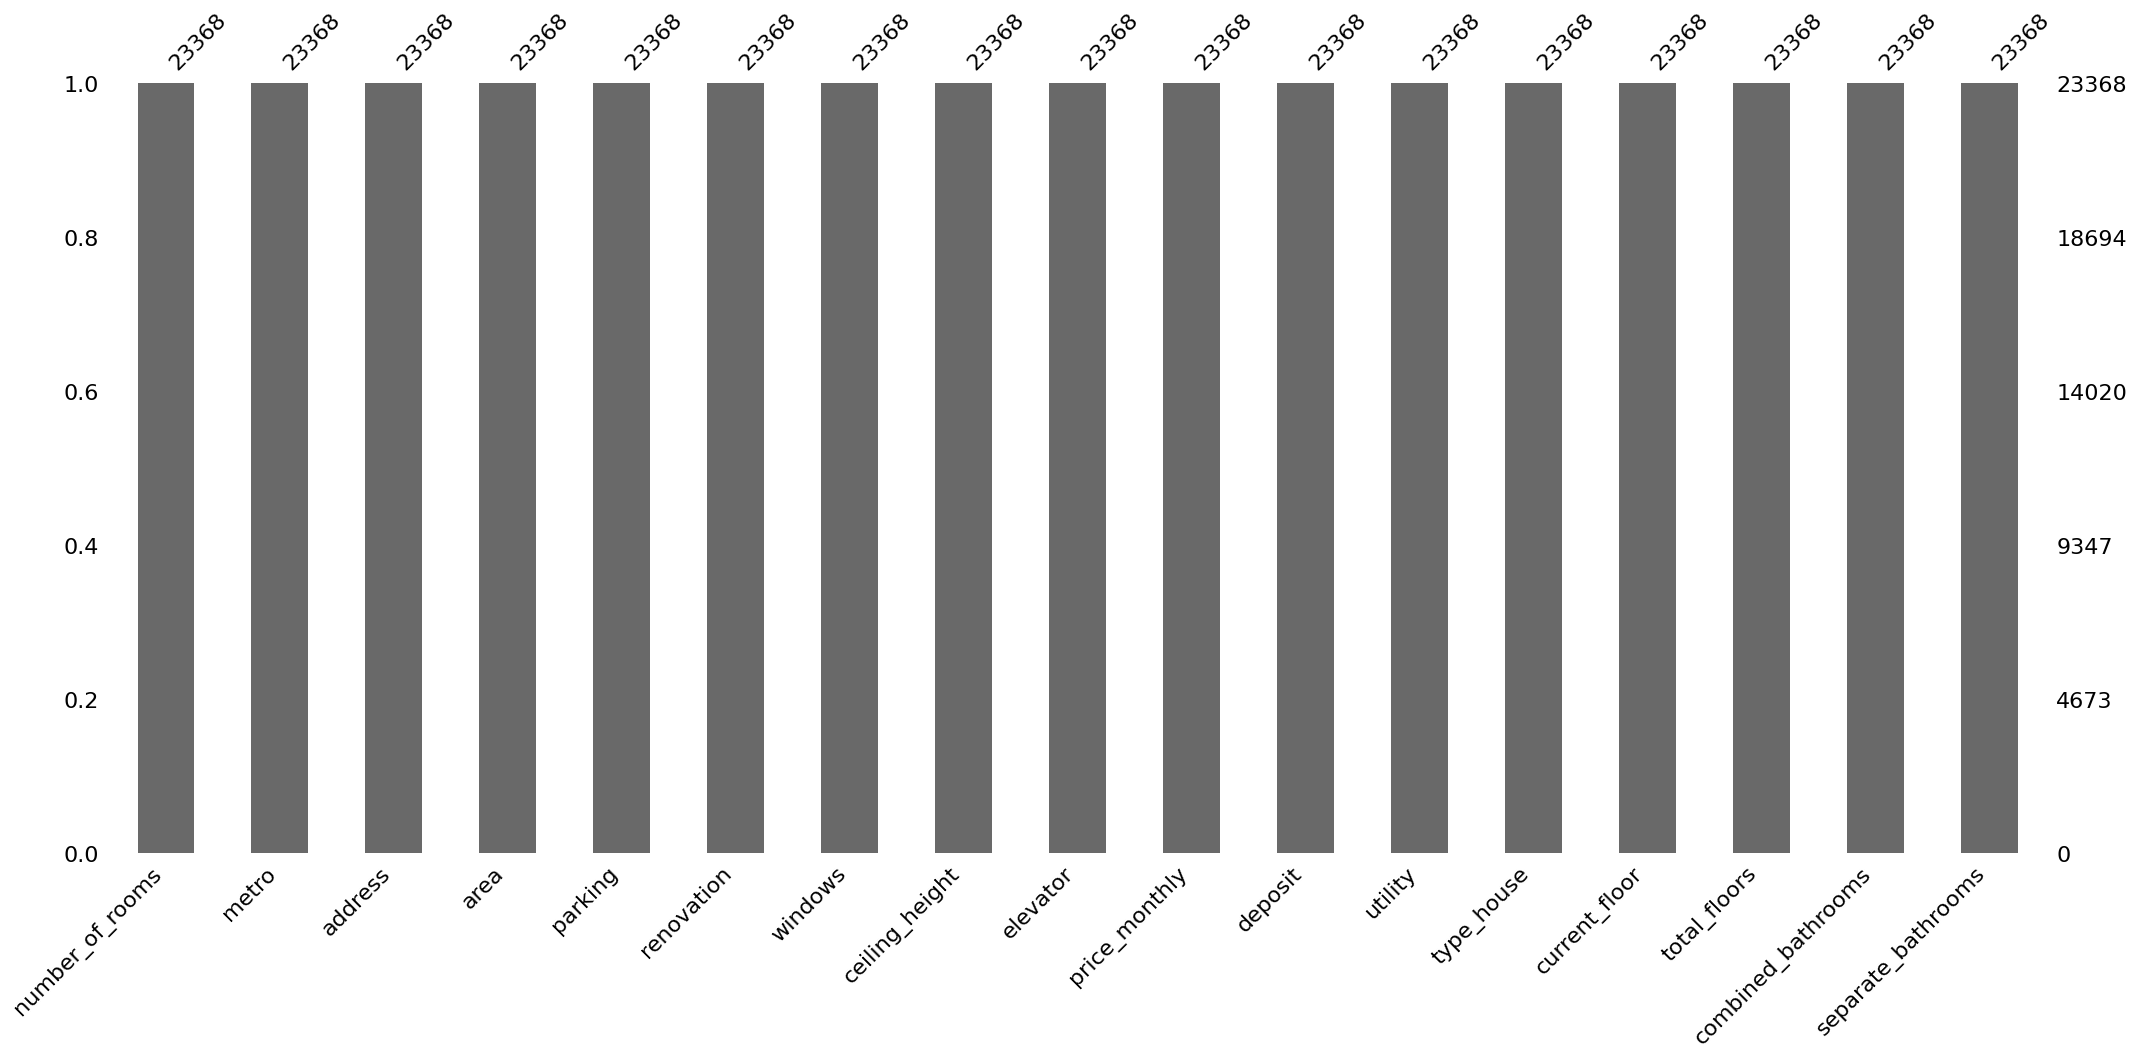

In [594]:
data_clean = data_clean.drop(columns=['bathroom']) 
msno.bar(data_clean) #на графике видно, что незаполненных значений у нас не осталось:)

In [595]:
data_clean.to_csv('clean_dataset.csv', index=False)